# Tonic sensitivity and expression variability of ISGs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
# data_path = '/data_volume/ifn_hbec/'
# fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Check the result in PBMCs

In [6]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/supp/'
data_path = '/data_volume/parameter_estimation/'

#### Read PBMC dataset and setup memento

In [7]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [8]:
def simplify_name(name):
    return name.split('.')[0]

In [12]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')

In [13]:
adata.obs['q'] = 0.07

In [14]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

#### Isolate the control cells and perform one sample test

In [15]:
adata_ctrl = adata.copy()[(adata.obs['cell']=='CD14+ Monocytes') & (adata.obs['stim']=='stim')].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [16]:
memento.create_groups(adata_ctrl, label_columns=['ind'])

In [17]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.7)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log


In [18]:
_, ctrl_var = memento.get_1d_moments(adata_ctrl, groupby='ALL')
ctrl_var.columns = ['gene', 'ctrl_var']

### Association between variability and tonic sensitivity

In [19]:
cm_adata = sc.read(data_path + 'result_1d/ifn/cM_20210104.h5ad')

In [20]:
df_1d = memento.get_1d_ht_result(cm_adata)
df_1d['de_fdr'] = memento.util._fdrcorrect(df_1d['de_pval'])

In [21]:
# ctrl_var = all_result['ciliated']['moments']['beta']['3'][1][['gene', 'time_step_0']].rename(columns={'time_step_0':'ctrl_var'})

In [22]:
de_genes = df_1d.query('de_fdr < 0.05 & de_coef > 0').gene.tolist()

In [23]:
tonic_sensitivy_df = pd.read_csv('../tonic_isg.txt', sep='\t')
tonic_sensitivy_df['gene'] = tonic_sensitivy_df['GeneSymbol'].str.upper()
tonic_sensitivy_df = tonic_sensitivy_df[['gene', 'IFN.FC.WT']].rename(columns={'IFN.FC.WT':'tonic'})

In [24]:
df = ctrl_var.merge(tonic_sensitivy_df, on='gene')#.query('gene in @de_genes')

In [25]:
with open('hv_genes.pkl', 'rb') as f:
    hv_genes = pkl.load(f)

In [26]:
stats.pearsonr(df['ctrl_var'], df['tonic'])

(0.24289142989205392, 0.021070471479779685)

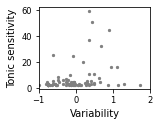

In [29]:
plt.figure(figsize=(2, 1.5))
plt.scatter(df['ctrl_var'], df['tonic'], color='grey', s=5)
# plt.scatter(df.query('gene in @hv_genes')['ctrl_var'], df.query('gene in @hv_genes')['tonic'], color='orange', s=15)
plt.xlabel('Variability');plt.ylabel('Tonic sensitivity');
plt.xlim(-1, 2)
plt.savefig(fig_path + 'tonic_sensitivity_pbmc.png', bbox_inches='tight', dpi=300)
